In [45]:
import pickle

import numpy as np
import xarray as xr
import pandas as pd

from glob import glob
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

from metpy.units import units
from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.calc import mixing_ratio_from_relative_humidity

from matplotlib.colors import BoundaryNorm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [145]:
site_list = ['CSSL', 'BSNFJE', 'BSNFDC', 'BSNFEX', 'CLN', 'AGD', 'ALTA', 'BCC', 'SLB', 'PVC',]
interval = 24

include_keys = ['T', 'R', 'Z', 'U', 'V', 'SPD', 'DIR']

In [146]:
gfs = xr.open_dataset('/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/gfs_aggregate_all.new.nc')
gfs = gfs.isel(level=np.where((gfs.level <= 1000)&(gfs.level>=200))[0])

gfs['longitude'] = gfs['longitude'] - 360

obs_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

metadata = pd.read_excel(obs_dir + 'Dataset_Metadata.xlsx')
metadata = metadata[np.in1d(metadata['code'], site_list)].set_index('code')

data = []

for i, site in enumerate(site_list):
        
    site_metadata = metadata.loc[site, :]
    print('Working: ', site)
    
    gfs_profile = gfs.sel(latitude=site_metadata['lat'], longitude=site_metadata['lon'], method='nearest')
    gfs_profile_df = pd.DataFrame()
    
    for data_var in gfs_profile.data_vars:
        
        if 'level' in gfs_profile[data_var].coords:
            
            for level in gfs_profile.level:
                
                if data_var.upper() == 'GH':
                    newname = '%s_%s'%('Z', level.values)

                else:
                    newname = '%s_%s'%(data_var.upper(), level.values)

#                 if data_var == 'r':
#                     p = level.values * units.millibar
#                     t = gfs_profile['t'].sel(level=level).values * units.kelvin
#                     r = gfs_profile[data_var].sel(level=level).values/100 * units.percent

#                     mixr = mixing_ratio_from_relative_humidity(r, t, p)
#                     q = specific_humidity_from_mixing_ratio(mixr)

#                     gfs_profile_df[newname.replace('R', 'Q')] = q

#                 else:
                gfs_profile_df[newname] = gfs_profile[data_var].sel(level=level)
        
        else:
            newname = data_var.upper()
            gfs_profile_df[newname] = gfs_profile[data_var]

        gfs_profile_df['time'] = gfs_profile.time
        gfs_profile_df = gfs_profile_df.set_index('time')
                
    f = glob('{}/clean/{}*.pd'.format(obs_dir, site))[0]
    site_data = pd.read_pickle(f)
    
    # Key match
    if 'slr'+str(interval) in str(site_data.keys):
        _interval = interval
    else:
        _interval = 24 if interval == 12 else 12 
    
    site_data = site_data.loc[:, [k for k in site_data.keys() if str(_interval) in k]]
    
    site_data = site_data.dropna()
    site_data = site_data[~site_data.index.duplicated(keep='first')]
    
    index = gfs_profile_df.index
    site_data = site_data.iloc[np.where(site_data.index > index[0])]

    gfs_profile_df_reduced = []
    tp_reduced = []
    
    tp = pd.DataFrame(gfs_profile_df.pop('TP'))

    for t in site_data.index:

        t0 = t-timedelta(hours=_interval-3)
        
        time_slice = gfs_profile_df.iloc[(np.where((index >= t0)&(index <= t)))].mean()
        time_slice['datetime_utc'] = t
        
        tp_time_slice = tp.iloc[(np.where((index >= t0)&(index <= t)))].sum()
        tp_time_slice['datetime_utc'] = t

        gfs_profile_df_reduced.append(pd.DataFrame(time_slice).T)
        tp_reduced.append(pd.DataFrame(tp_time_slice).T)

    gfs_profile_df = pd.concat(gfs_profile_df_reduced).set_index('datetime_utc').sort_index()
    tp_df = pd.concat(tp_reduced).set_index('datetime_utc').sort_index()
    
    gfs_profile_df.insert(0, 'swe_mm_model', tp_df)

    # Time match
    gfs_profile_df = gfs_profile_df[np.in1d(gfs_profile_df.index, site_data.index)]
    site_data = site_data[np.in1d(site_data.index, gfs_profile_df.index)]

    # Clean up
    gfs_profile_df = gfs_profile_df.loc[site_data[~site_data.duplicated()].index, :]
    site_data = site_data[~site_data.duplicated()]
    
    # Insert obs into profile
    for k in site_data.keys()[::-1]:
        gfs_profile_df.insert(0, k.replace('%d'%_interval, ''), site_data[k])

    gfs_profile_df = gfs_profile_df.dropna()
    gfs_profile_df.insert(0, 'site', np.full(gfs_profile_df.shape[0], fill_value=site))
    
    gfs_profile_df = gfs_profile_df.reset_index().rename(columns={'datetime_utc':'time'})
    data.append(gfs_profile_df.set_index(['site', 'time']))
    del gfs_profile_df
    
data = pd.concat(data)#.reset_index()
# doy = np.array([t.strftime('%j') for t in data.pop('datetime_utc')])

swe_cutoff = 2.54 # 0.1"
data = data[data['swe_mm'] > swe_cutoff]

slr_cutoff_low = 1
data = data[data['slr'] >= slr_cutoff_low]

slr_cutoff_high = 50
data = data[data['slr'] <= slr_cutoff_high]

for k in ['depth_mm', 'snow_mm']:
    try:
        data.pop(k)
    except:
        pass

reorder_slr = data.pop('slr')
data.insert(0, 'slr', reorder_slr)

data_gfs = data.sort_index()
data_gfs

Working:  CSSL
Working:  BSNFJE
Working:  BSNFDC
Working:  BSNFEX
Working:  CLN
Working:  AGD
Working:  ALTA
Working:  BCC
Working:  SLB
Working:  PVC


slr     swe_mm swe_mm_model    Z_200    Z_250  \
site time                                                                  
AGD  2015-01-16 23:00:00  6.82   5.590000            0  11948.2  10552.9   
     2015-01-19 22:00:00  6.66   3.050000         0.72  11845.5  10448.2   
     2015-01-28 09:00:00  7.00   5.080000         3.47  12028.9  10567.5   
     2015-01-28 23:00:00  4.16   3.050000        10.48    11966  10501.4   
     2015-02-01 23:00:00  6.66   6.100000            0    11838  10441.2   
...                        ...        ...          ...      ...      ...   
SLB  2019-05-20 02:00:00  4.29  17.780001       11.875  11812.1  10392.1   
     2019-05-21 02:00:00  8.33   3.050000       4.8125    11704  10250.7   
     2019-05-22 02:00:00  4.41  17.270000        9.375  11728.3  10273.4   
     2019-05-23 02:00:00  3.00  25.400000       19.875    11757  10292.7   
     2019-05-24 02:00:00  3.88  26.160000      25.1875  11817.1    10336   

                            Z_300    Z_350    Z_400    Z_450    Z_500  ...  \
site time                                                              ...   
AGD  2015-01-16 23:00:00  9361.25  8309.38   7365.7  6509.82  5726.46  ...   
     2015-01-19 22:00:00  9272.38  8240.37  7315.93  6475.82  5703.82  ...   
     2015-01-28 09:00:00  9352.35  8291.58  7342.92  6486.67  5706.53  ...   
     2015-01-28 23:00:00  9294.09  8244.31  7306.32   6458.1  5682.35  ...   
     2015-02-01 23:00:00  9255.49  8211.36  7276.53   6428.8   5652.6  ...   
...                           ...      ...      ...      ...      ...  ...   
SLB  2019-05-20 02:00:00  9202.92  8156.76  7217.21  6364.52  5585.06  ...   
     2019-05-21 02:00:00  9068.34   8046.7  7131.12   6297.2  5530.62  ...   
     2019-05-22 02:00:00   9090.9     8063  7140.85  6302.26  5532.16  ...   
     2019-05-23 02:00:00   9092.2  8059.31  7137.15  6298.26  5528.14  ...   
     2019-05-24 02:00:00  9120.27  8081.45  7160.29  6324.17  5555.93  ...   

                          DIR_650  DIR_700  DIR_750  DIR_800  DIR_850  \
site time                                                               
AGD  2015-01-16 23:00:00  258.401  235.465   192.74  113.729  113.729   
     2015-01-19 22:00:00  279.624  281.875  256.567  139.585  139.585   
     2015-01-28 09:00:00  210.963  203.289  187.794  145.123  145.123   
     2015-01-28 23:00:00  259.148  246.972  227.006   186.47   186.47   
     2015-02-01 23:00:00  329.856  324.301  287.889  152.845  152.845   
...                           ...      ...      ...      ...      ...   
SLB  2019-05-20 02:00:00  187.781  176.011  154.147   138.14  138.085   
     2019-05-21 02:00:00  222.685  220.416  210.026  195.602  195.661   
     2019-05-22 02:00:00  281.578  288.086  264.673  249.003  248.958   
     2019-05-23 02:00:00  129.874  158.311  187.199  174.679  174.598   
     2019-05-24 02:00:00   164.19  156.834    138.3  130.709  130.668   

                          DIR_900  DIR_925  DIR_950  DIR_975 DIR_1000  
site time                                                              
AGD  2015-01-16 23:00:00  113.692  113.824  113.836  113.836  113.836  
     2015-01-19 22:00:00  139.584  139.585  139.584  139.584  139.584  
     2015-01-28 09:00:00  145.123  145.123  145.123  145.123  145.123  
     2015-01-28 23:00:00   186.47   186.47  186.333  186.333  186.333  
     2015-02-01 23:00:00  152.845  152.845  152.845  152.845  152.845  
...                           ...      ...      ...      ...      ...  
SLB  2019-05-20 02:00:00    138.1  138.072  138.121  138.111  138.108  
     2019-05-21 02:00:00  195.572  195.612   195.59  195.636  195.641  
     2019-05-22 02:00:00  248.953  249.026  249.051   249.01  248.934  
     2019-05-23 02:00:00  174.642  174.724  174.659  174.679   174.64  
     2019-05-24 02:00:00  130.667  130.746  130.741  130.662  130.711  

[2114 rows x 138 columns]

In [147]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'
figdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/output/slr_figures/'
outdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/output/slr_models/'

flist = glob(obdir + 'combined/*.pd')

flist = []
for site in site_list:

    for interval in [interval]:        
        flist.append(glob(obdir + 'combined/%s*%d*.pd'%(site, interval)))

flist = np.hstack(flist)
flist = [f for f in flist if '.isobaric.' in f]
print('Source files:\n%s\n'%'\n'.join(flist))

min_slr, max_slr = 0, 50
max_T_650 = 0 + 273.15
min_swe_mm = 2.54 * 5

data = []
for f in flist:

    site = f.split('/')[-1].split('_')[0]

    df = pd.read_pickle(f)

    keys = ['slr', 'swe_mm']
    keys.extend(np.hstack([[k for k in df.keys()
                            if ((vt in k) & (k.split('_')[0] in include_keys))] 
                           for vt in ['mean']]))

    df = df.loc[:, keys].rename(columns={[k for k in keys if 'swe' in k][0]:'swe_mm'})
    df = df.loc[:, :].rename(columns={[k for k in keys if 'swe' in k][0]:'swe_mm'})
    df = df.rename(columns={[k for k in keys if 'slr' in k][0]:'slr'})
    df = df.drop(columns=[k for k in keys if 'auto' in k])

    # df.insert(0, 'site', np.full(df.index.size, fill_value=site, dtype='U10'))
    doy = [int(pd.to_datetime(d).strftime('%j')) for d in df.index]
    #df.insert(2, 'day_of_year', doy)
    
    site = 'CLN' if site == 'CLNX' else site
    df.insert(0, 'site', np.full(df.shape[0], fill_value=site))
    df = df.reset_index().set_index(['site', 'time'])

    data.append(df)#.reset_index().drop(columns='time'))

data = pd.concat(data, sort=False)

# Treat the mean value as the instantaneous value for later applications,
# we can change this behavior later on if desired. 
# An alternate method would be to keep the 'mean' tag through training 
# and choose behavior upon application
data = data.rename(columns={k:k.replace('_mean', '') for k in data.keys()})

data = data[data['slr'] >= min_slr]
data = data[data['slr'] <= max_slr]
data = data[data['T_650'] <= max_T_650]
data = data[(data['swe_mm'] >= min_swe_mm)&(data['swe_mm'] <= 150)]

data['slr'] = np.log(data['slr'])

# data.pop('swe_mm')

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

slr = data['slr']

print('\nTotal: %d'%len(data))

level_keys = [k.split('_') for k in data.keys()]

keep_keys = []
for level_key in level_keys:
    try:
        level = int(level_key[-1])
    except:
        keep_keys.append('_'.join(level_key))
    else:
        if ((level <= 750) & (level >= 400)):
            keep_keys.append('_'.join(level_key))
            
data_era5 = data[keep_keys]
data_era5

Source files:
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CSSL_1980_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BSNFJE_2005_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BSNFDC_2005_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BSNFEX_2012_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CLNX_1999_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/AGD_2004_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/ALTA_1980_2020.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/BCC_2004_2019.24h.isobaric.pd
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observati

slr     swe_mm       T_400      U_400  \
site time                                                              
CSSL 1980-12-24 08:00:00  2.428354  73.914000  246.225357  18.406658   
     1980-12-25 08:00:00  3.129264  26.670000  250.884064  18.786196   
     1981-01-27 08:00:00  1.963565  99.822000  242.931335  24.602304   
     1982-01-04 08:00:00  2.219203  95.250000  240.300171  39.317730   
     1982-03-02 08:00:00  2.626372  43.180000  242.766907  30.019180   
...                            ...        ...         ...        ...   
PVC  2019-03-06 09:00:00  1.393766  15.750000  244.030945  29.233946   
     2019-03-07 00:00:00  1.241269  66.040001  243.649231  29.857000   
     2019-03-09 00:00:00  2.644755  26.160000  236.453598  11.370615   
     2019-03-24 09:00:00  1.488400  20.070000  240.712250   6.634520   
     2019-04-10 00:00:00  1.713798  18.290001  245.641418  27.521292   

                              V_400         Z_400      R_400    SPD_400  \
site time                                                                 
CSSL 1980-12-24 08:00:00  -3.137820  72587.742188  72.578270  19.235920   
     1980-12-25 08:00:00   0.861099  73196.601562  54.583828  19.549681   
     1981-01-27 08:00:00  -5.946640  70753.914062  80.904640  26.366074   
     1982-01-04 08:00:00 -14.744175  69654.421875  76.489769  43.136806   
     1982-03-02 08:00:00  28.586180  70584.953125  59.662491  41.898182   
...                             ...           ...        ...        ...   
PVC  2019-03-06 09:00:00   3.671127  71272.156250  81.770363  30.502495   
     2019-03-07 00:00:00  17.792686  70985.781250  93.590691  35.290901   
     2019-03-09 00:00:00  11.680881  69435.812500  84.779236  17.521595   
     2019-03-24 09:00:00   0.066582  70986.984375  86.012825   9.716001   
     2019-04-10 00:00:00  12.027770  71954.617188  86.663445  31.139175   

                             DIR_400       T_450  ...      R_700    SPD_700  \
site time                                         ...                         
CSSL 1980-12-24 08:00:00  279.288300  252.118469  ...  16.351063   8.661427   
     1980-12-25 08:00:00  267.803802  257.287354  ...  63.347305  17.767212   
     1981-01-27 08:00:00  283.684784  248.975861  ...  81.514839  13.410635   
     1982-01-04 08:00:00  289.818604  246.107025  ...  87.250778  17.480814   
     1982-03-02 08:00:00  226.340256  248.146225  ...  93.667717  26.411037   
...                              ...         ...  ...        ...        ...   
PVC  2019-03-06 09:00:00  262.821594  250.533539  ...  77.097771  10.360246   
     2019-03-07 00:00:00  240.079437  250.074524  ...  84.687355  13.757596   
     2019-03-09 00:00:00  225.297287  243.459778  ...  87.850800   7.987436   
     2019-03-24 09:00:00  254.113953  247.277573  ...  79.812386   5.705149   
     2019-04-10 00:00:00  247.092026  251.857773  ...  54.498116  10.449845   

                             DIR_700       T_750     U_750      V_750  \
site time                                                               
CSSL 1980-12-24 08:00:00  259.757019  277.750366  2.814170   3.722433   
     1980-12-25 08:00:00  233.751282  275.552490  8.751738  12.080474   
     1981-01-27 08:00:00  242.369751  269.670105  5.196771   7.109074   
     1982-01-04 08:00:00  248.782043  261.750580  7.566258  10.020692   
     1982-03-02 08:00:00  212.154968  269.972137  7.793048  17.249710   
...                              ...         ...       ...        ...   
PVC  2019-03-06 09:00:00  216.732834  271.804199 -1.523372   3.893346   
     2019-03-07 00:00:00  213.416321  273.347351  0.213892   5.174452   
     2019-03-09 00:00:00  214.013962  271.084808  0.707074   3.335784   
     2019-03-24 09:00:00  252.376755  272.738800  1.202156   1.232291   
     2019-04-10 00:00:00  240.729156  280.924927  2.884305   3.509713   

                                 Z_750      R_750    SPD_750     DIR_750  
site time                                                        

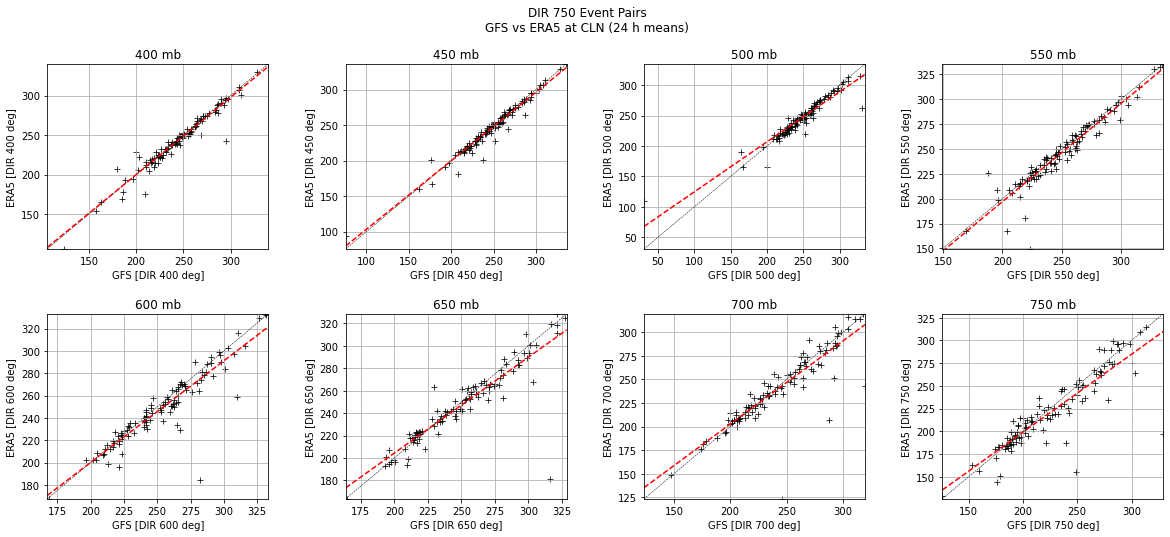

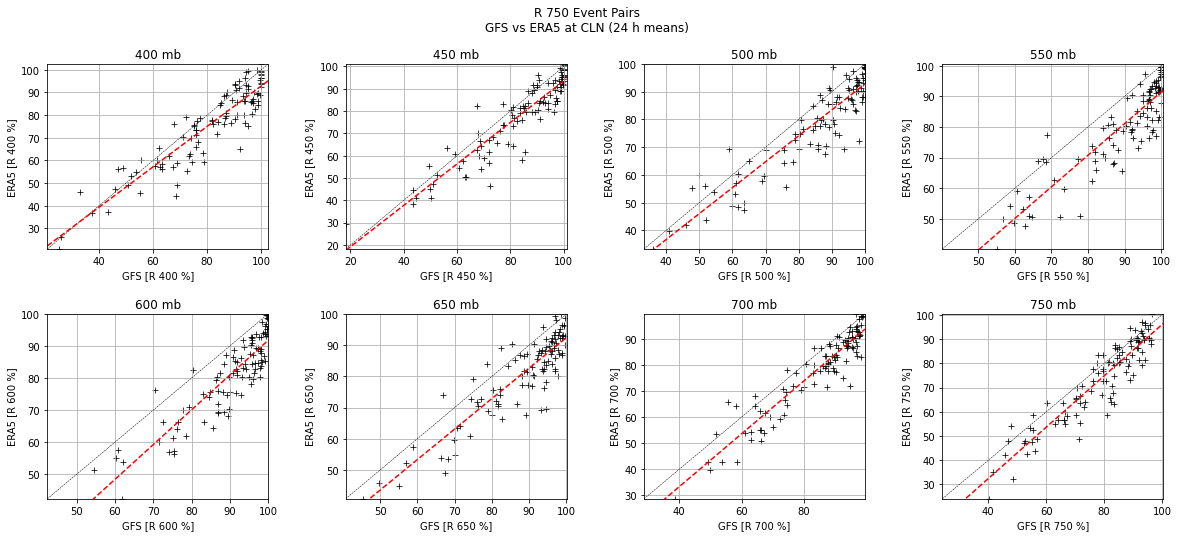

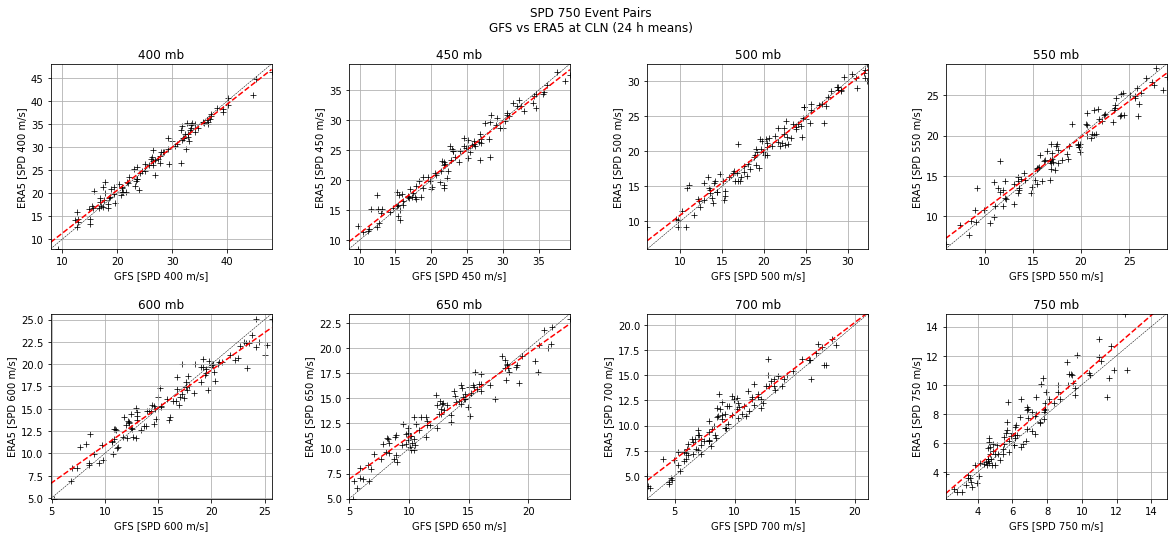

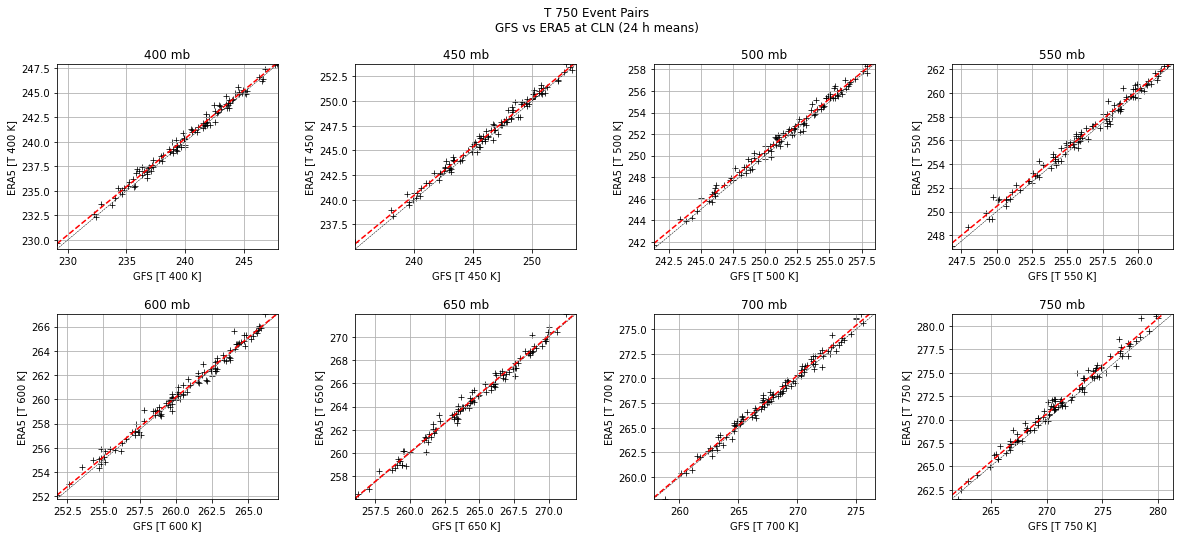

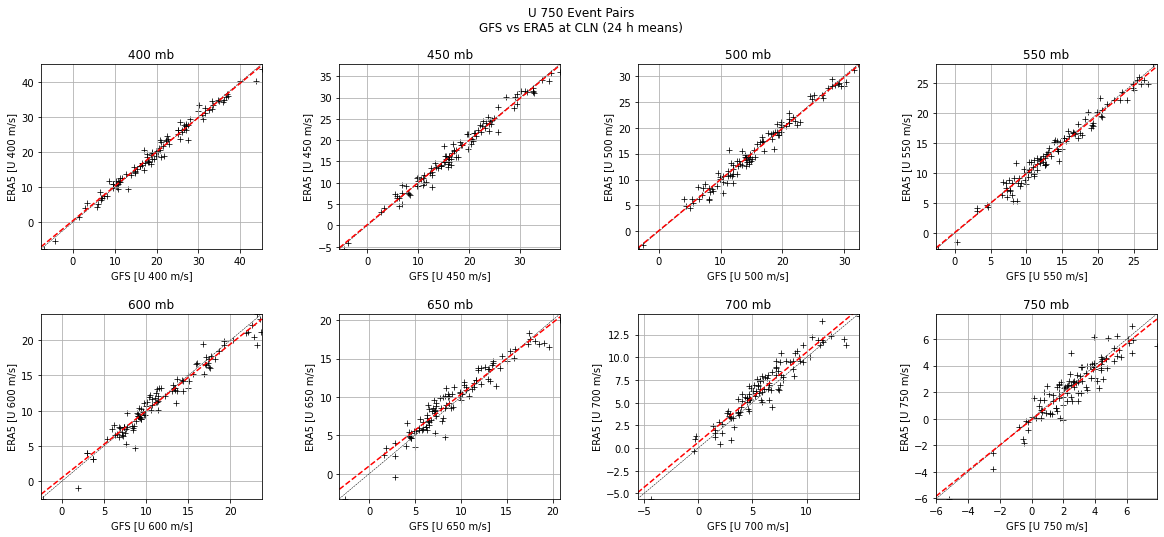

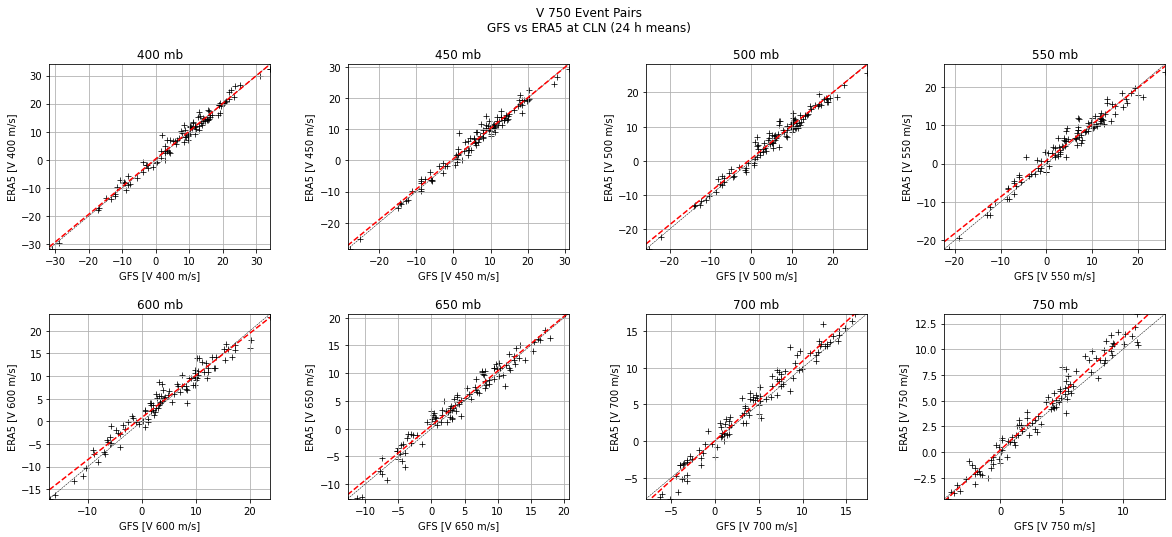

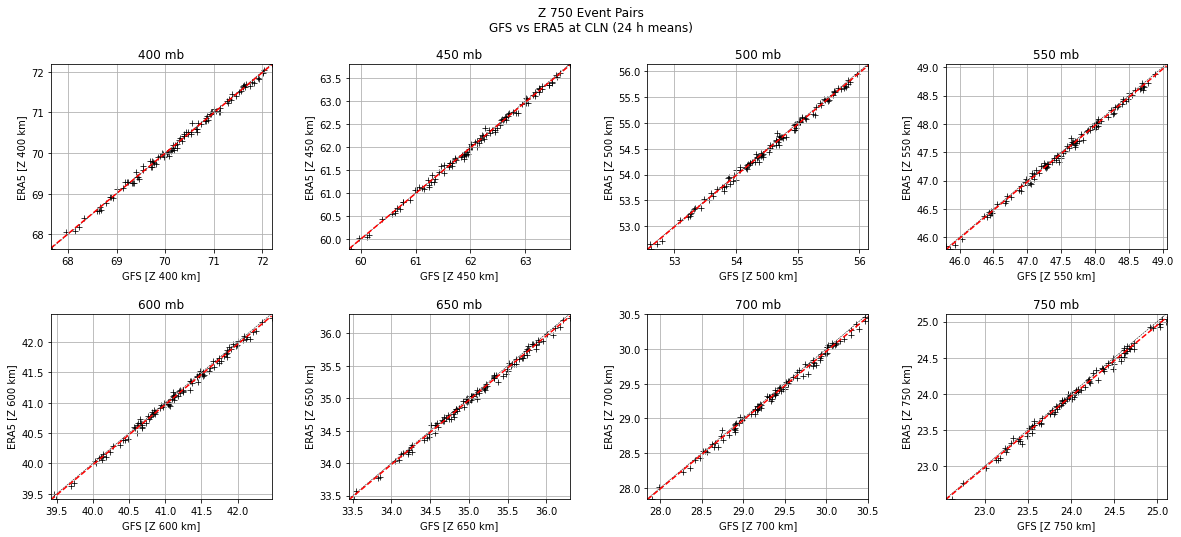

In [148]:
site = 'CLN'

overlap_times = data_era5.loc[site].iloc[np.where(
    np.isin(data_era5.loc[site].index, data_gfs.loc[site].index))].index

overlap_keys = data_gfs.keys()[np.in1d(data_gfs.keys(), data_era5.keys())]

era5_sample = data_era5.loc[site].loc[overlap_times, overlap_keys]
gfs_sample = data_gfs.loc[site].loc[overlap_times, overlap_keys]
# print(era5_sample.shape, gfs_sample.shape)

era5_sample = era5_sample[~era5_sample.duplicated()]
# gfs_sample = gfs_sample[~gfs_sample.duplicated()]
# print(era5_sample.shape, gfs_sample.shape)

units = {'R':'%', 'T':'K', 'U':'m/s', 'V':'m/s', 'Z':'km', 'SPD':'m/s', 'DIR':'deg'}

unique_keys = np.unique([k.split('_')[0] for k in overlap_keys if k != 'swe_mm'])
for key in unique_keys:
    
    if key not in ['slr', 'swe_mm']:
    
        select_keys = [k for k in overlap_keys if k.split('_')[0] == key]
        fig, axs = plt.subplots(2, 4, facecolor='w', figsize=(20, 8))
        fig.subplots_adjust(hspace=0.35, wspace=0.35)

        axs = axs.flatten()

        for ax, plot_key in zip(axs, select_keys):

            x, y = gfs_sample[plot_key].astype(float), era5_sample[plot_key].astype(float)
            
            x = (x*9.81/1000) if key == 'Z' else x
            y = (y/1000.) if key == 'Z' else y

            ax.scatter(x, y, color='k', marker='+', linewidth=0.75)

            maxval = max(max(x), max(y))
            minval = min(min(x), min(y))
            diag = np.linspace(minval, maxval, 10)

            ax.plot(diag, diag, 'k--', linewidth=0.5)
            
            m, b = np.polyfit(x, y, 1)
            xfit = np.linspace(minval, maxval, 10)
            fit = xfit*m+b
            ax.plot(xfit, fit, 'r--')

            ax.set_title(plot_key.split('_')[-1] + ' mb')

            ax.set_xlabel('GFS [%s %s]'%(plot_key.replace('_', ' '), units[key]))
            ax.set_ylabel('ERA5 [%s %s]'%(plot_key.replace('_', ' '), units[key]))

            ax.set_xlim([minval, maxval])
            ax.set_ylim([minval, maxval])
            ax.grid()
        
        plt.suptitle('%s Event Pairs\nGFS vs ERA5 at %s (%d h means)'%(plot_key.replace('_', ' '), site, interval))
        plt.show()

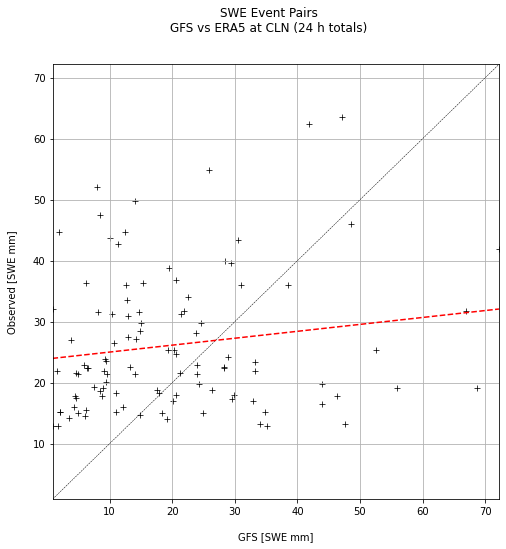

In [149]:
gfs_swe_sample = data_gfs.loc[site].loc[overlap_times, ['swe_mm', 'swe_mm_model']]

prism = xr.open_dataset('/uufs/chpc.utah.edu/common/home/horel-group/archive/20210320/models/gfsds/2021032000/GFSDS_20210320_0000_000.nc')['prism']
prism_ratio = prism.sel(lat=site_metadata['lat'], lon=site_metadata['lon'], method='nearest').values[0]

fig, ax = plt.subplots(1, facecolor='w', figsize=(8, 8))
fig.subplots_adjust(hspace=0.35, wspace=0.35)

xk, yk = 'swe_mm_model', 'swe_mm'
x, y = gfs_swe_sample[xk].astype(float), gfs_swe_sample[yk].astype(float)

x = x * prism_ratio

ax.scatter(x, y, color='k', marker='+', linewidth=0.75)

maxval = max(max(x), max(y))
minval = min(min(x), min(y))
diag = np.linspace(minval, maxval, 10)

ax.plot(diag, diag, 'k--', linewidth=0.5)

m, b = np.polyfit(x, y, 1)
xfit = np.linspace(minval, maxval, 10)
fit = xfit*m+b
ax.plot(xfit, fit, 'r--')

ax.set_xlabel('\nGFS [SWE mm]')
ax.set_ylabel('Observed [SWE mm]\n')

ax.set_xlim([minval, maxval])
ax.set_ylim([minval, maxval])
ax.grid()

plt.suptitle('%s Event Pairs\nGFS vs ERA5 at %s (%d h totals)'%('SWE', site, interval))
plt.show()

In [150]:
era_samples, gfs_samples = [], []

for site in site_list:
    
    try:

        overlap_times = data_era5.loc[site].iloc[np.where(
            np.isin(data_era5.loc[site].index, data_gfs.loc[site].index))].index

        overlap_keys = data_gfs.keys()[np.in1d(data_gfs.keys(), data_era5.keys())]

        era5_sample = data_era5.loc[site].loc[overlap_times, overlap_keys]
        gfs_sample = data_gfs.loc[site].loc[overlap_times, overlap_keys]
        # print(era5_sample.shape, gfs_sample.shape)

        era5_sample = era5_sample[~era5_sample.duplicated()]
        # gfs_sample = gfs_sample[~gfs_sample.duplicated()]
        # print(era5_sample.shape, gfs_sample.shape)
        
    except:
        print(site, 'failed')
        #raise

    else:
        era_samples.append(era5_sample)
        gfs_samples.append(gfs_sample)
        
era_samples = pd.concat(era_samples)
gfs_samples = pd.concat(gfs_samples)

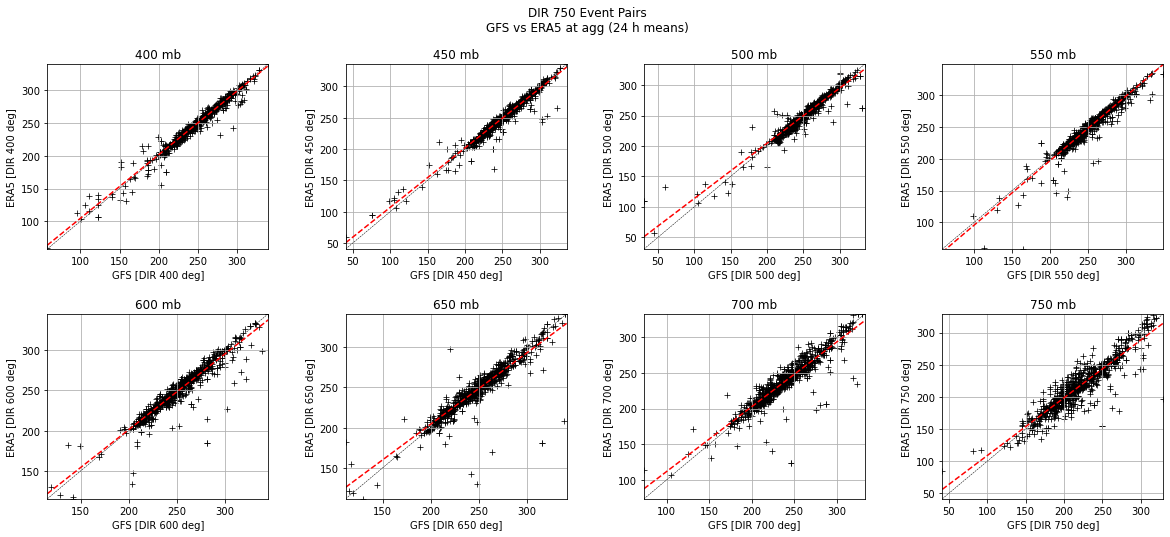

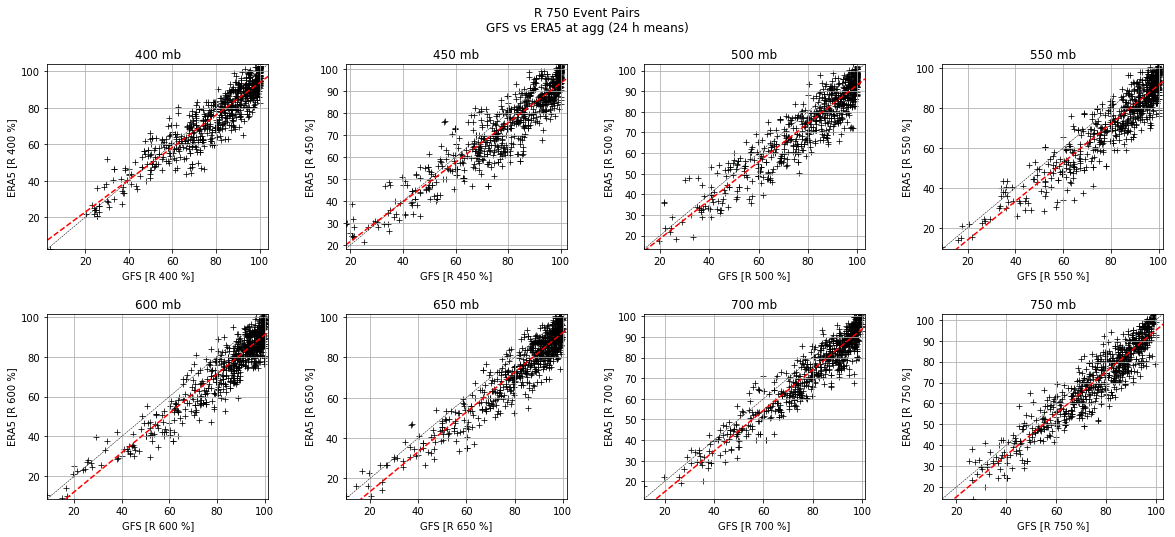

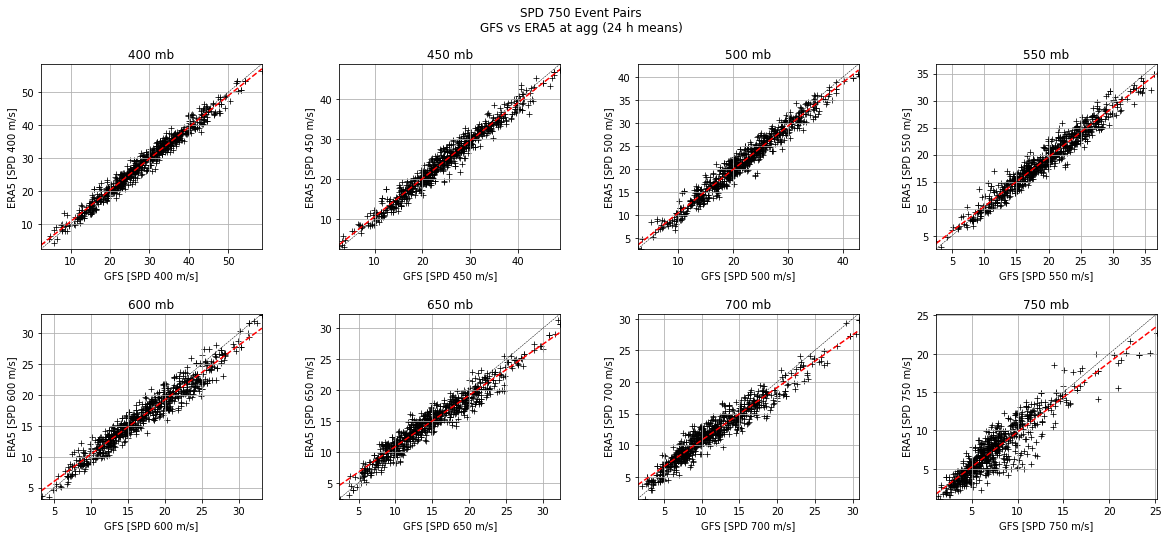

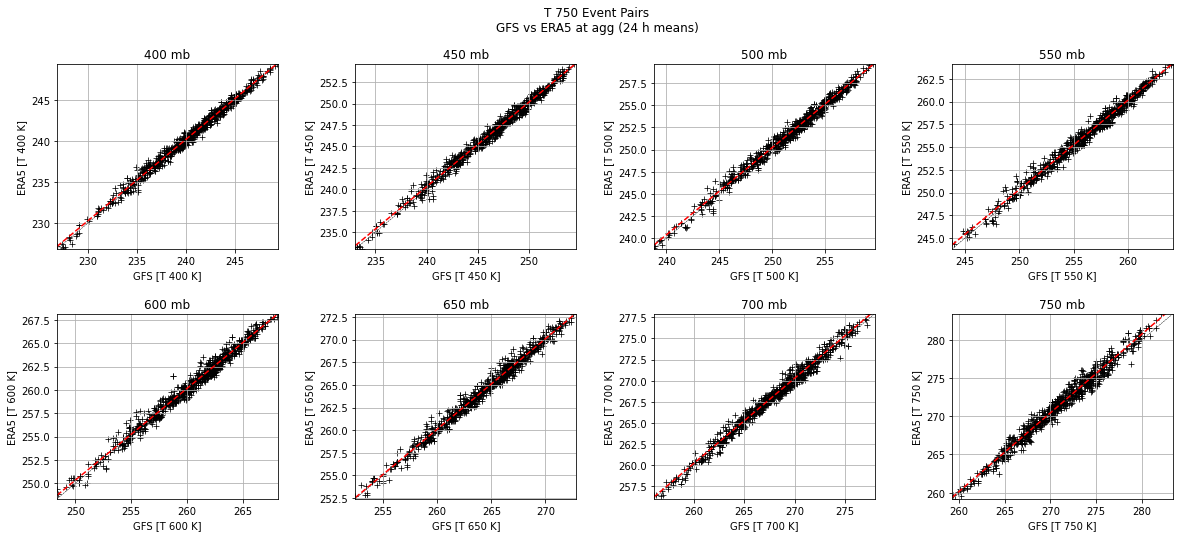

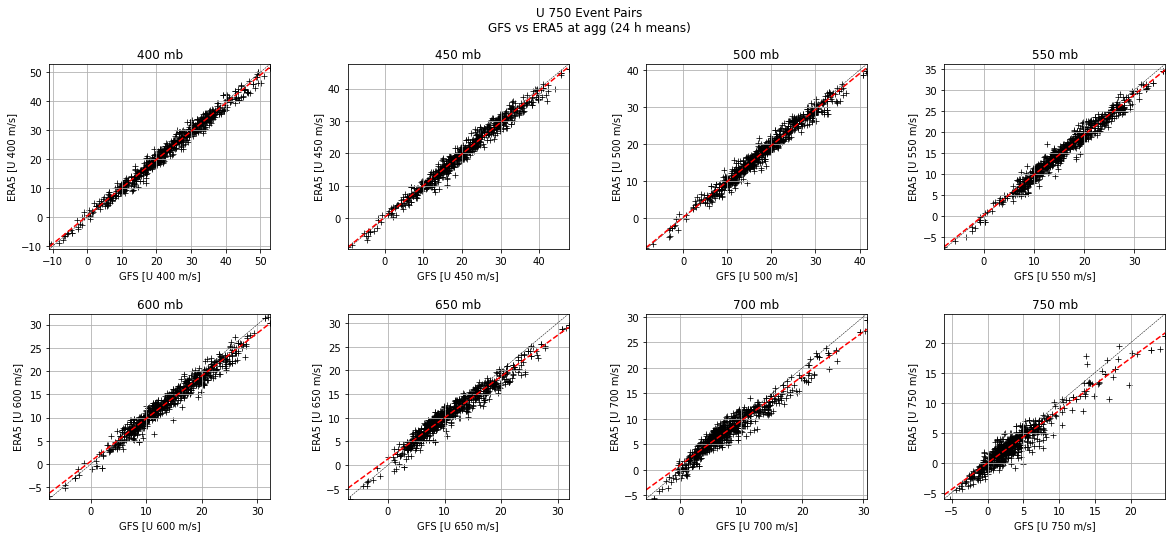

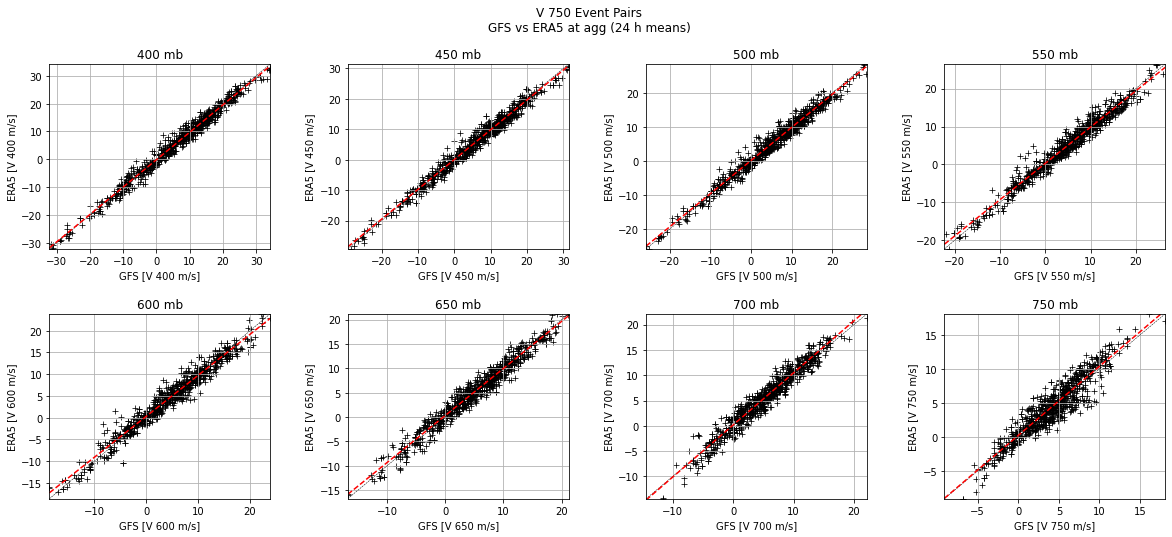

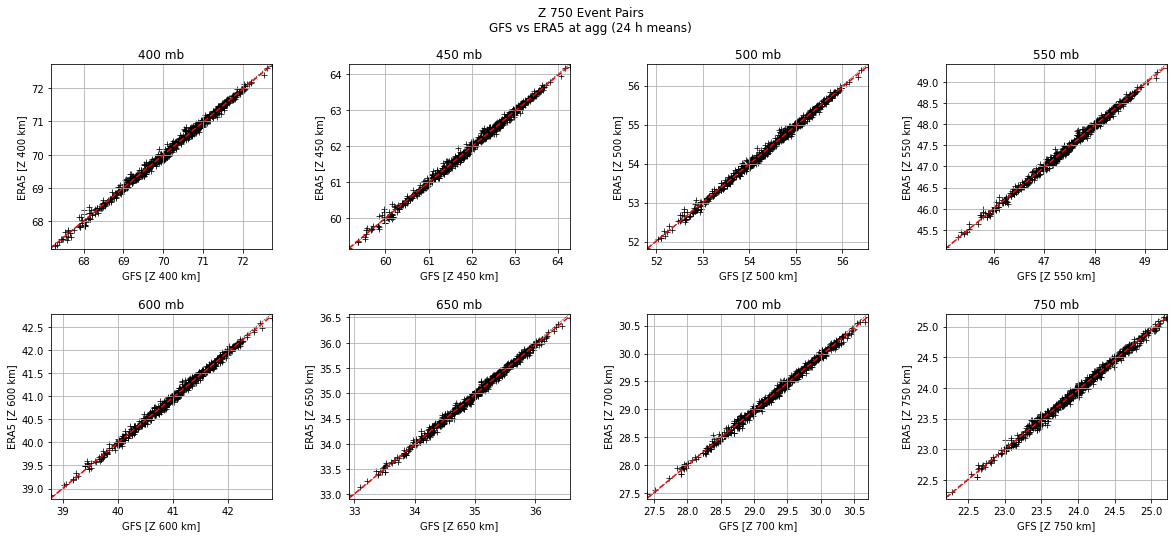

In [151]:
units = {'R':'%', 'T':'K', 'U':'m/s', 'V':'m/s', 'Z':'km', 'SPD':'m/s', 'DIR':'deg'}

unique_keys = np.unique([k.split('_')[0] for k in overlap_keys if k != 'swe_mm'])
for key in unique_keys:
    
    if key not in ['slr', 'swe_mm']:
    
        select_keys = [k for k in overlap_keys if k.split('_')[0] == key]
        fig, axs = plt.subplots(2, 4, facecolor='w', figsize=(20, 8))
        fig.subplots_adjust(hspace=0.35, wspace=0.35)

        axs = axs.flatten()

        for ax, plot_key in zip(axs, select_keys):

            x, y = gfs_samples[plot_key].astype(float), era_samples[plot_key].astype(float)
            
            x = (x*9.81/1000) if key == 'Z' else x
            y = (y/1000.) if key == 'Z' else y

            ax.scatter(x, y, color='k', marker='+', linewidth=0.75)

            maxval = max(max(x), max(y))
            minval = min(min(x), min(y))
            diag = np.linspace(minval, maxval, 10)

            ax.plot(diag, diag, 'k--', linewidth=0.5)
            
            m, b = np.polyfit(x, y, 1)
            xfit = np.linspace(minval, maxval, 10)
            fit = xfit*m+b
            ax.plot(xfit, fit, 'r--')

            ax.set_title(plot_key.split('_')[-1] + ' mb')

            ax.set_xlabel('GFS [%s %s]'%(plot_key.replace('_', ' '), units[key]))
            ax.set_ylabel('ERA5 [%s %s]'%(plot_key.replace('_', ' '), units[key]))

            ax.set_xlim([minval, maxval])
            ax.set_ylim([minval, maxval])
            ax.grid()
        
        plt.suptitle('%s Event Pairs\nGFS vs ERA5 at %s (%d h means)'%(plot_key.replace('_', ' '), 'agg', interval))
        plt.show()